In [25]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import NamedTuple
import math
from enum import Enum, auto
import re

In [26]:
class Actor(Enum):
    GAITNET = "gaitnet"
    CONTACTNET = "contactnet"

In [27]:
file_name_regex = re.compile(r'([a-zA-Z]+)_eval_d(\d+(?:\.\d+)?)_v(\d+(?:\.\d+)?)\.csv')
"""match groups:
 - 1: network (gaitnet or contactnet)
 - 2: terrain difficulty (float)
 - 3: command velocity (float)
"""

class DataPoint(NamedTuple):
    network: Actor
    terrain_difficulty: float
    command_velocity: float
    distances: np.ndarray
    success: np.ndarray

    @staticmethod
    def from_csv(file_path: Path) -> "DataPoint":
        df = pd.read_csv(file_path)

        match = file_name_regex.match(file_path.name)
        if match is None:
            raise ValueError(f"Filename {file_path.name} does not match expected pattern")

        network_str, terrain_difficulty, command_velocity = match.groups()
        network = Actor(network_str)
        terrain_difficulty = float(terrain_difficulty)
        command_velocity = float(command_velocity)

        distances = df['distance'].to_numpy()
        success = df['truncated'].to_numpy().astype(bool)
        
        return DataPoint(
            network=network,
            terrain_difficulty=terrain_difficulty,
            command_velocity=command_velocity,
            distances=distances,
            success=success
        )

In [28]:
data_folder = Path.cwd() / "data"
data_files = list(data_folder.glob("*.csv"))
data_points = [DataPoint.from_csv(fp) for fp in data_files]
data_points

[DataPoint(network=<Actor.GAITNET: 'gaitnet'>, terrain_difficulty=0.15, command_velocity=0.2, distances=array([], dtype=object), success=array([], dtype=bool)),
 DataPoint(network=<Actor.GAITNET: 'gaitnet'>, terrain_difficulty=0.05, command_velocity=0.1, distances=array([1.542986 , 1.4688739, 1.548454 , 1.5875239, 1.5055923, 1.5428694,
        1.5391436, 1.5403891, 1.5588679, 1.571378 , 1.5479715, 1.5552818,
        1.5756528, 1.4955713, 1.5284911, 1.5806409, 1.5390509, 1.5572302,
        1.4821926, 1.5560508, 1.5912644, 1.5169588, 1.4998717, 1.506277 ,
        1.6189188, 1.591873 , 1.5580553, 1.5313517, 1.5907012, 1.5684539,
        1.5099435, 1.5248041, 1.581871 , 1.4946363, 1.6205235, 1.5920204,
        1.4851471, 1.5439864, 1.6055124, 1.5861313, 1.4346808, 1.5466903,
        1.5203902, 1.5081066, 1.5670826, 1.5431743, 1.5541711, 1.5154157,
        1.5960463, 1.5509806]), success=array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True

/home/owen/miniconda3/envs/env_isaaclab/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/owen/miniconda3/envs/env_isaaclab/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


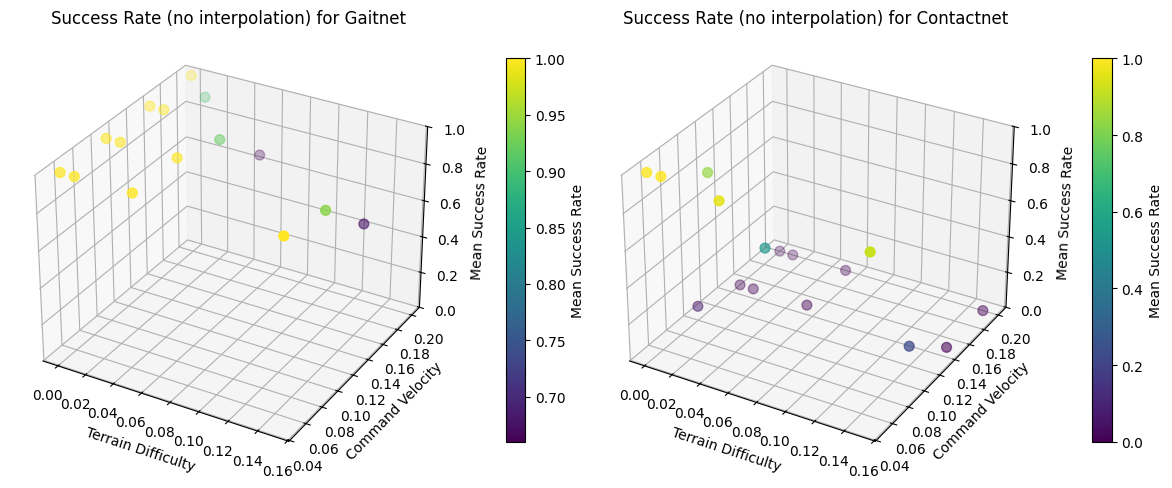

In [29]:
# plot a 3d surface plot of terrain difficulty (x), command velocity (y), and mean success rate (z)
# one plot for each network

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

for network, ax in zip(Actor, [ax1, ax2]):
    network_data = [dp for dp in data_points if dp.network == network]
    
    xs = np.array([dp.terrain_difficulty for dp in network_data])
    ys = np.array([dp.command_velocity for dp in network_data])
    zs = np.array([np.mean(dp.success) for dp in network_data])

    # Plot raw points without interpolation
    sc = ax.scatter(xs, ys, zs, c=zs, cmap='viridis', s=50, depthshade=True)

    ax.set_title(f'Success Rate (no interpolation) for {network.value.capitalize()}')
    ax.set_xlabel('Terrain Difficulty')
    ax.set_ylabel('Command Velocity')
    ax.set_zlabel('Mean Success Rate')
    ax.set_zlim(0, 1)
    # set tight layout
    plt.tight_layout()
    fig.colorbar(sc, ax=ax, shrink=0.7, pad=0.1, label='Mean Success Rate')